# Task 2: Exploratory Data Analysis  
**Objective**: Summarize enriched dataset, visualize trends, gaps, correlations; overlay events; derive 7+ key insights.  
Uses enriched data from Task 1 (`ethiopia_fi_unified_enriched_*.csv`).  
Date: January 31, 2026

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")


df = pd.read_csv("../data/processed/ethiopia_fi_unified_enriched_20260131.csv", 
                 parse_dates=['observation_date'])

print("Enriched shape:", df.shape)
print(df.record_type.value_counts())

Enriched shape: (49, 35)
record_type
observation    34
event          12
target          3
Name: count, dtype: int64


## Dataset Overview & Quality

By record_type:
 record_type
observation    34
event          12
target          3
Name: count, dtype: int64

By pillar:
 pillar
ACCESS           16
NaN              16
USAGE            11
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

By confidence:
 confidence
high      45
medium     4
Name: count, dtype: int64

Observations per year & indicator:
 indicator_code  ACC_4G_COV  ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  \
year                                                                    
2014                     0          0               0               0   
2017                     0          0               0               0   
2021                     0          0               1               0   
2023                     1          0               0               0   
2024                     0          1               2               0   
2025                     1          2               0               1   

indicator_code  ACC_OWNERSHIP  AFF_DATA_INC

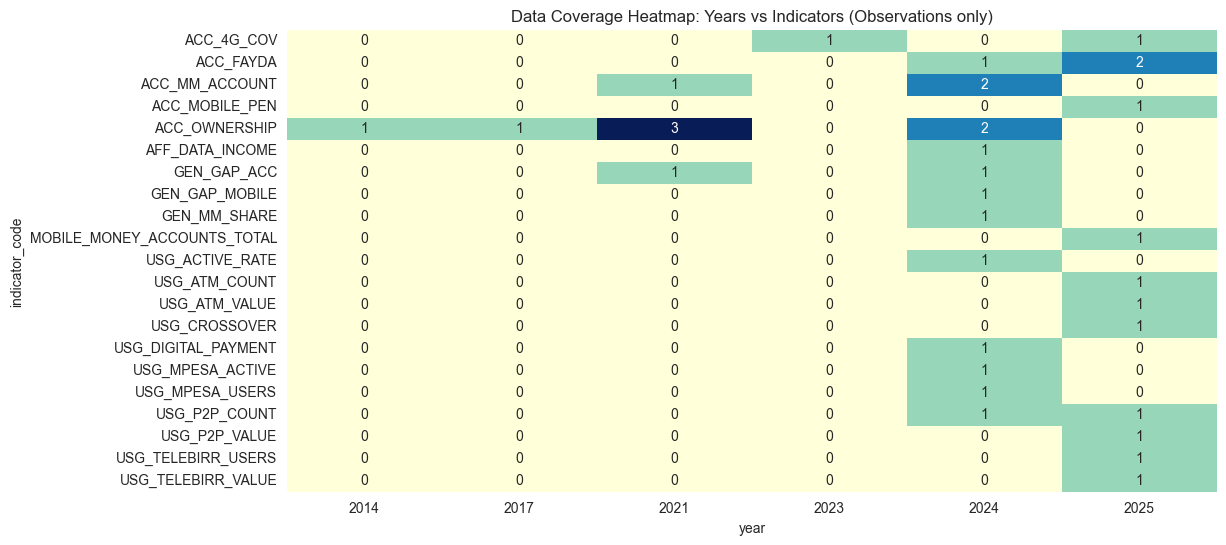

In [2]:
# Summary by record_type, pillar, confidence
print("By record_type:\n", df['record_type'].value_counts())
print("\nBy pillar:\n", df['pillar'].value_counts(dropna=False))
print("\nBy confidence:\n", df['confidence'].value_counts(dropna=False))

# Temporal coverage (observations only)
obs = df[df['record_type'] == 'observation'].copy()
obs['year'] = obs['observation_date'].dt.year
temporal_pivot = obs.pivot_table(index='year', columns='indicator_code', 
                                 values='value_numeric', aggfunc='count', fill_value=0)
print("\nObservations per year & indicator:\n", temporal_pivot)

plt.figure(figsize=(12, 6))
sns.heatmap(temporal_pivot.T, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title("Data Coverage Heatmap: Years vs Indicators (Observations only)")
plt.savefig("../reports/figures/eda_temporal_coverage.png", dpi=150)
plt.show()

## Access: Account Ownership Trajectory & Growth

Account Ownership Changes:
    observation_date  value_numeric  change_pp  annual_growth_pp
0        2014-12-31           22.0        NaN               NaN
1        2017-12-31           35.0       13.0          4.332345
2        2021-12-31           46.0       11.0          2.750000
3        2021-12-31           56.0       10.0               inf
4        2021-12-31           36.0      -20.0              -inf
5        2024-11-29           49.0       13.0          4.462641
43       2024-12-31           49.0        0.0          0.000000


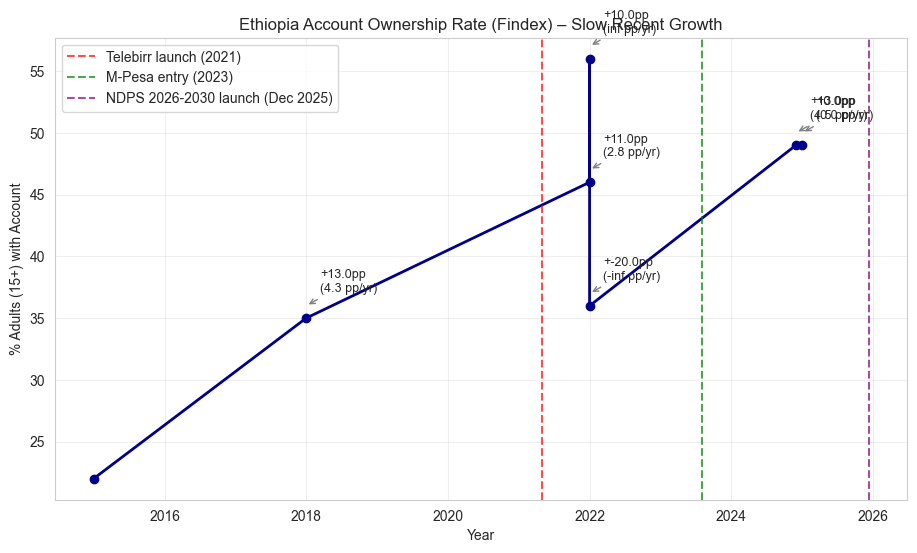

In [3]:
acc_own = obs[obs['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

# Calculate changes
acc_own['change_pp'] = acc_own['value_numeric'].diff()
acc_own['years'] = acc_own['observation_date'].diff().dt.days / 365.25
acc_own['annual_growth_pp'] = acc_own['change_pp'] / acc_own['years']

print("Account Ownership Changes:\n", acc_own[['observation_date', 'value_numeric', 'change_pp', 'annual_growth_pp']])

plt.figure(figsize=(11, 6))
plt.plot(acc_own['observation_date'], acc_own['value_numeric'], marker='o', linewidth=2, color='darkblue')
plt.title("Ethiopia Account Ownership Rate (Findex) – Slow Recent Growth")
plt.ylabel("% Adults (15+) with Account")
plt.xlabel("Year")

# Annotate changes
for i in range(1, len(acc_own)):
    row = acc_own.iloc[i]
    prev = acc_own.iloc[i-1]
    plt.annotate(f'+{row["change_pp"]:.1f}pp\n({row["annual_growth_pp"]:.1f} pp/yr)', 
                 (row['observation_date'], row['value_numeric'] + 1), 
                 xytext=(10, 10), textcoords='offset points', fontsize=9,
                 arrowprops=dict(arrowstyle="->", color='gray'))

# Event lines
plt.axvline(pd.to_datetime('2021-05-01'), color='red', ls='--', alpha=0.7, label='Telebirr launch (2021)')
plt.axvline(pd.to_datetime('2023-08-01'), color='green', ls='--', alpha=0.7, label='M-Pesa entry (2023)')
plt.axvline(pd.to_datetime('2025-12-08'), color='purple', ls='--', alpha=0.7, label='NDPS 2026-2030 launch (Dec 2025)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("../reports/figures/eda_account_ownership_trend.png", dpi=150)
plt.show()

## Usage & Mobile Money – Registered vs Active Gap

In [4]:
mm_indicators = ['ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT', 'MOBILE_MONEY_ACCOUNTS_TOTAL', 'ACTIVE_MM_ACCOUNTS_PCT']
mm_df = obs[obs['indicator_code'].isin(mm_indicators)].sort_values(['indicator_code', 'observation_date'])

print("Mobile & Usage Coverage:\n", mm_df[['indicator_code', 'observation_date', 'value_numeric', 'source_name']])

# Registered vs Active bar (2025 focus)
reg_2025 = mm_df[(mm_df['indicator_code'] == 'MOBILE_MONEY_ACCOUNTS_TOTAL') & (mm_df['observation_date'].dt.year == 2025)]
act_2025 = mm_df[(mm_df['indicator_code'] == 'ACTIVE_MM_ACCOUNTS_PCT') & (mm_df['observation_date'].dt.year == 2025)]

if not reg_2025.empty and not act_2025.empty:
    reg_val = reg_2025['value_numeric'].values[0]
    act_pct = act_2025['value_numeric'].values[0] / 100
    act_val = reg_val * act_pct
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Registered (2025)', 'Active (2025)'], [reg_val, act_val], color=['#1f77b4', '#ff7f0e'])
    plt.title("Mobile Money Accounts: Massive Registrations vs Low Activation (2025)")
    plt.ylabel("Number of Accounts")
    plt.text(0, reg_val * 1.05, f"{reg_val:,.0f}", ha='center', fontsize=11)
    plt.text(1, act_val * 1.05, f"~{act_val:,.0f} ({act_pct*100:.0f}%)", ha='center', fontsize=11)
    plt.savefig("../reports/figures/eda_registered_vs_active_gap.png", dpi=150)
    plt.show()

Mobile & Usage Coverage:
                  indicator_code observation_date  value_numeric  \
6                ACC_MM_ACCOUNT       2021-12-31   4.700000e+00   
7                ACC_MM_ACCOUNT       2024-11-29   9.450000e+00   
44               ACC_MM_ACCOUNT       2024-12-31   1.940000e+01   
46  MOBILE_MONEY_ACCOUNTS_TOTAL       2025-12-01   1.360000e+08   
45          USG_DIGITAL_PAYMENT       2024-12-31   2.100000e+01   

                                          source_name  
6                                  Global Findex 2021  
7                                  Global Findex 2024  
44         Global Findex 2025 (via Shega/BirrMetrics)  
46            National Bank of Ethiopia / BirrMetrics  
45  Global Findex 2025 (via BirrMetrics/LinkedIn ref)  


## Event Timeline Overlay & Correlations

Cataloged Events:
    observation_date                                        source_name  \
33       2021-05-17                                      Ethio Telecom   
41       2021-09-01                                                NBE   
34       2022-08-01                                               News   
35       2023-08-01                                          Safaricom   
36       2024-01-01                                               NIDP   
37       2024-07-29                                                NBE   
38       2024-10-01                                          EthSwitch   
47       2025-06-01      Fayda mandatory linkage for accounts in Addis   
39       2025-10-27                                          EthSwitch   
48       2025-12-08  National Digital Payments Strategy 2026-2030 D...   
42       2025-12-15                                               News   
40       2025-12-18                                      NBE/EthSwitch   

          category

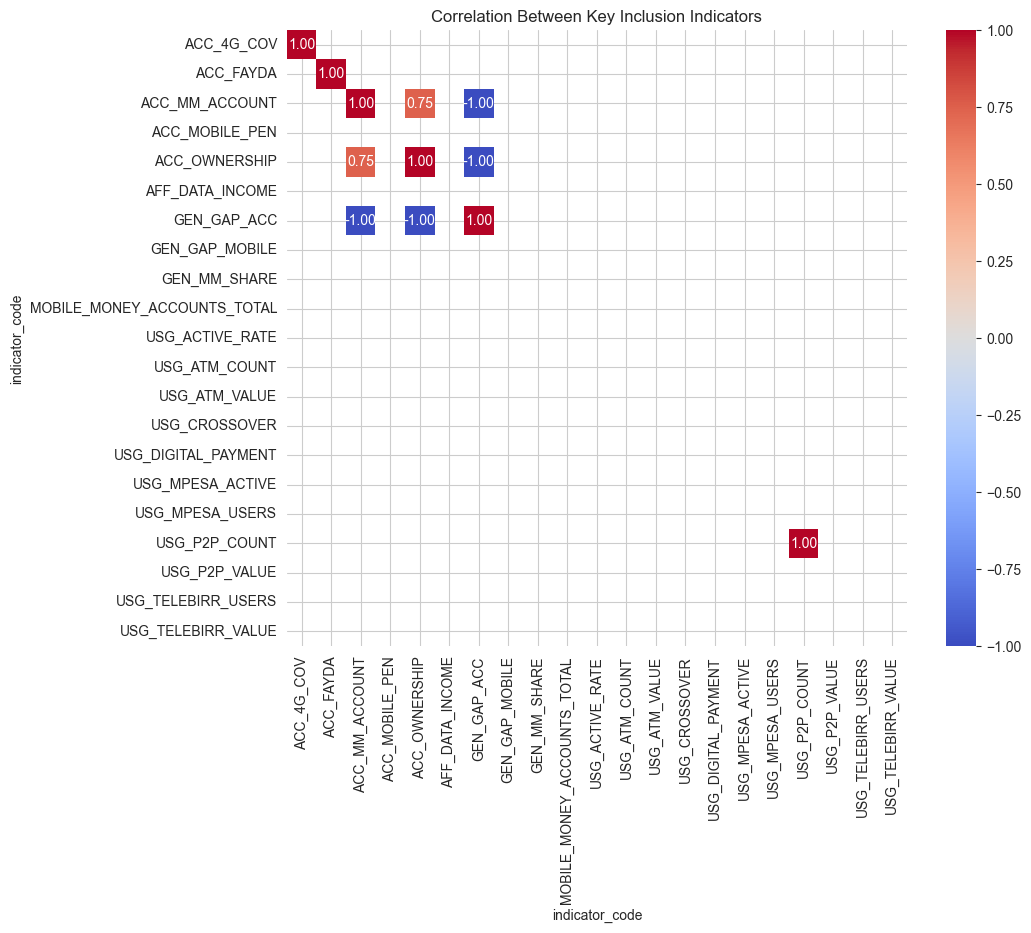

In [5]:
events = df[df['record_type'] == 'event'][['observation_date', 'source_name', 'category']].sort_values('observation_date')
print("Cataloged Events:\n", events)

# Simple correlation matrix (numeric obs only)
numeric_obs = obs.pivot_table(index='observation_date', columns='indicator_code', values='value_numeric')
corr = numeric_obs.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Between Key Inclusion Indicators")
plt.savefig("../reports/figures/eda_correlation_matrix.png", dpi=150)
plt.show()

### 7 Key Insights from EDA (with Evidence)

1. **Stagnant recent access growth**  
   Account ownership increased only +3pp (46% → 49%) from 2021 to 2024 (Findex 2025), despite massive digital account registrations. Annual growth slowed dramatically post-2021.

2. **Explosive registrations but activation crisis**  
   Mobile money accounts reached ~139.5 million by 2025 (NBE), up from ~12M in 2020, but only ~15–16% are active → huge dormant gap explains limited Findex impact.

3. **Digital payment usage remains low**  
   Only ~21% of adults made/received a digital payment in 2024 (Findex 2025 / NBE), far below potential given registrations; urban-rural and gender divides persist.

4. **Persistent structural gaps**  
   Gender gap unchanged at ~15pp (57% men vs 42% women with accounts). Urban areas show much higher usage (~40% digital payments) vs rural (~16%).

5. **Policy momentum in 2025**  
   NDPS 2026–2030 launched Dec 2025 targets active usage, interoperability, gender/rural gaps. Fayda digital ID at >30M enrolled → foundational enabler for KYC/activation.

6. **Leading indicators point to future potential**  
   Strong supply growth (transactions, registrations) and infrastructure (Fayda, EthSwitch IPS) are positive, but demand-side activation is the bottleneck.

7. **Major data limitations**  
   Sparse Findex points (every ~3 years); heavy reliance on NBE supply-side proxies. No frequent demand-side usage tracking → high uncertainty for short-term forecasts.

These insights highlight Ethiopia's "momentum without maturity" paradox: supply scales fast, but active, inclusive usage lags badly.

In [6]:
# Optional: save summary stats to CSV for report
acc_own.to_csv("../reports/figures/acc_ownership_changes.csv", index=False)